In [66]:
import numpy as np
import pandas as pd
import string
import nltk
import time

from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV

rng = np.random

In [3]:
df = pd.read_csv('../data/news_headlines.csv')

print('Total rows: %d\n10 random rows:' % (len(df)))
df.iloc[rng.choice(np.arange(len(df)), 10), :]

Total rows: 1000001
10 random rows:


,publish_date,headline_text
133823,20050122,storms hit nsw wine harvest
427061,20090206,encouraging employment
909431,20160419,paul dimattina fined 500 for punching bar manager
11016,20030319,public urged to back australian troops
123737,20040429,former longreach rouseabout becomes priest
556662,20110604,indian yoga guru hungry for justice
819668,20140110,lake tyers threaten court action over new mana...
315262,20070419,japan mulls beefing up gun laws
543341,20111107,group kept in the dark on memorial decision
231913,20060717,israel to continue offensive


In [19]:
# break dataset by year
print('min date = %d\nmax date = %d' % (np.min(df['publish_date']), np.max(df['publish_date'])))

df_year = {}

for y in np.arange(2003, 2018):
    subdf = df[(df['publish_date'] >= y * 1e4) & (df['publish_date'] < (y + 1) * 1e4)]
    df_year[y] = subdf
    
    print('year %d length = %d' % (y, len(subdf)))

df_year.keys()

min date = 20030219
max date = 20171231
year 2003 length = 59343
year 2004 length = 65975
year 2005 length = 66320
year 2006 length = 61568
year 2007 length = 69431
year 2008 length = 71591
year 2009 length = 68867
year 2010 length = 67715
year 2011 length = 69919
year 2012 length = 78547
year 2013 length = 81016
year 2014 length = 73361
year 2015 length = 70004
year 2016 length = 52162
year 2017 length = 44182


dict_keys([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

total unique words in entire corpus (takes a bit to process): **80570**

``` Python
len(np.unique(word_tokenize(' '.join(df['headline_text']))))
```

In [75]:
# This one takes a little while
def sanitise_words(a):
    en_stopwords = set(stopwords.words('english'))
    sanitised = []
    
    for w in a:
        # stopwords do not include punctuation
        # isalpha() is also excluding numbers
        # use and (w.isalpha() or w.isnumeric)
        if not w in en_stopwords and w.isalpha():
            sanitised.append(w)
    
    return sanitised


In [76]:
# Let's histogram the entire corpus. Get all headlines, sanitise and histogram
def word_histogram(df):
    headlines = np.array(df['headline_text'])
    headlines = ' '.join(headlines)
    headlines = word_tokenize(headlines)
    headlines = sanitise_words(headlines)
    word_hist = {}
    
    for w in headlines:
        word_hist[w] = (word_hist.get(w) or 0) + 1
        
    return word_hist


In [100]:
whist = word_histogram(df)

dfhist = pd.DataFrame.from_dict(whist, orient='index')
dfhist.columns = ['count']
dfhist = dfhist.sort_values('count', ascending=False)

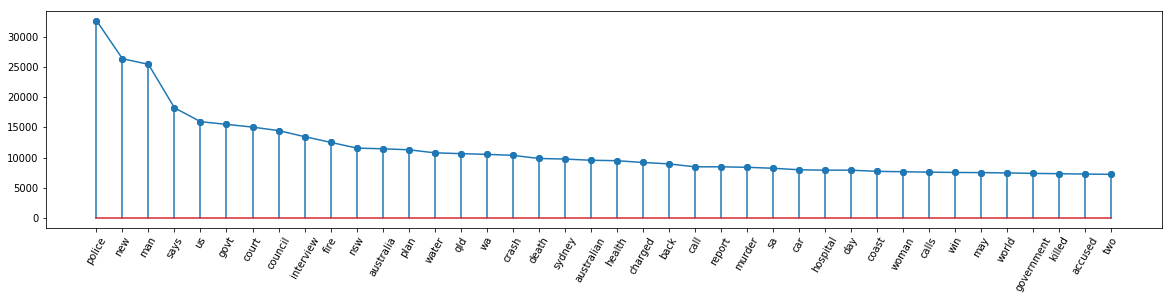

In [104]:
# plots a line+stem plot with most common words across a dfhist
plt.figure(figsize=(20,4))
plt.plot(dfhist.iloc[0:40,:], 'o-')
plt.stem(dfhist.iloc[0:40,:])
plt.xticks(rotation=60)
plt.show()

In [35]:
inertias = []
n_clusters = np.arange(5, 31)

for k in n_clusters:
    km = KMeans(n_clusters=k, n_jobs=4, max_iter=300)
    km.fit(data)
    
    inertias.append(km.inertia_)


In [ ]:
KMeans?

In [79]:
'...'.isalpha()

False